# Projekt Zespołowy - Zastosowanie oraz porównanie istniejących architektur do klasyfikacji obrazów na przykładzie CIFAR-10

## Wstęp

### Cel

Celem projektu jest omówienie oraz porównanie wybranych modeli uczenia maszynowego do klasyfiakcji obrazów na przykładzie zbioru CIFAR-10.

### Dataset

CiFar-10 to zbiór danych, który składa się z 60000 kolorowych obrazów o rozmiarze 32x32 pikseli, podzielonych na 10 klas. Każda klasa zawiera 6000 obrazów. Zbiór ten zawiera 50000 obrazów treningowych oraz 10000 obrazów testowych.

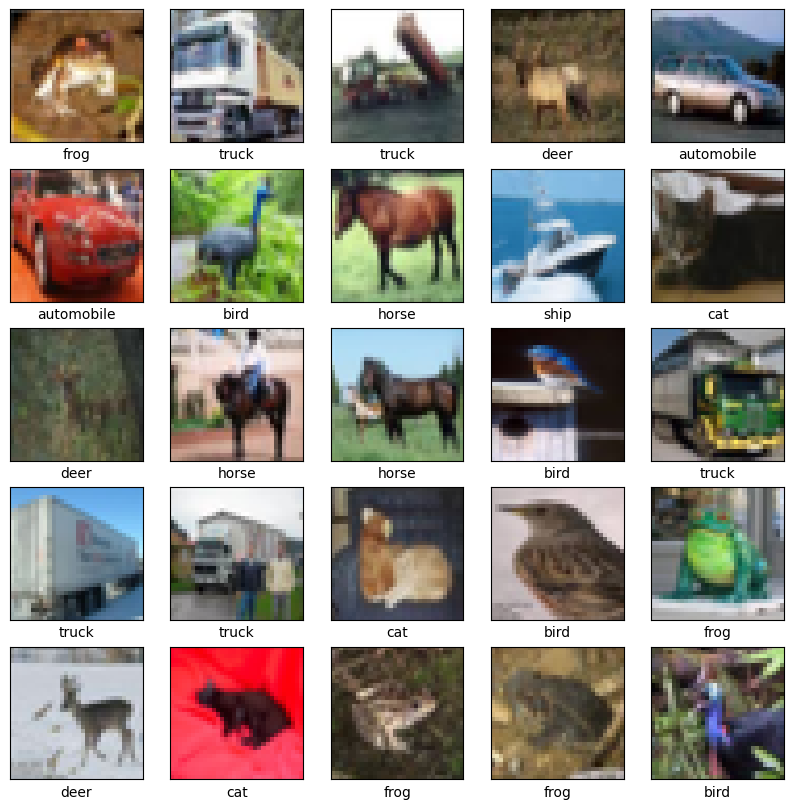

In [ ]:

# Import oraz demonstracja danych
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Etkiety klas
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Wyświetlenie przykładowych obrazów
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()


Wszystkich klas jest po równo, co oznacza, że zbiór jest zbalansowany:

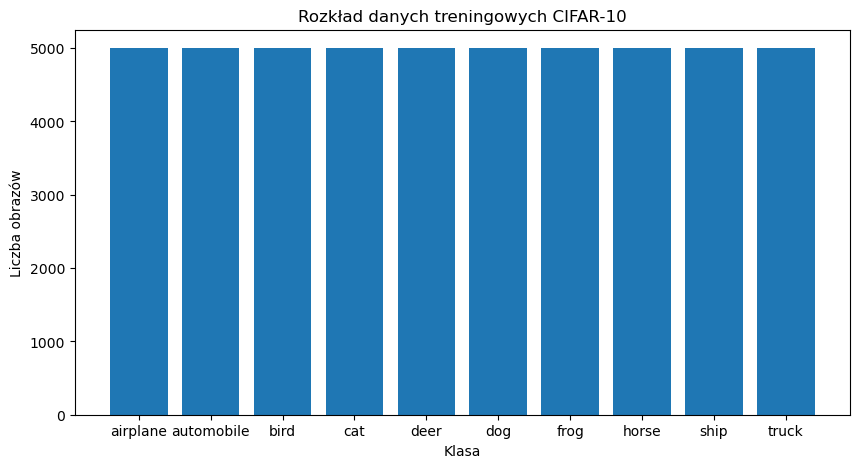

In [3]:
# Analiza rozkładu danych treningowych
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Wyświetlenie rozkładu klas
plt.figure(figsize=(10, 5))
plt.bar(class_names, counts)
plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład danych treningowych CIFAR-10')
plt.show()


### Wyniki modeli SOTA w porównaniu z ludźmi

![Przykładowe wyniki](images/przykladowe_wyniki.png)

<font size="3"><i>Ho-Phuoc, T. (2018). CIFAR10 to Compare Visual Recognition Performance between Deep Neural Networks and Humans. The University of Danang – University of Science and Technology.<font><i>

Jak widać, modele widzenia komputerowego "State Of The Art" oparte na sieciach neuronowych od kilku lat osigają wyniki przewyższające ludzkie.

## Uczenie płytkie

### Regresja logistyczna 

Regresja logistyczna jest w pewnym sensie rozszerzeniem regresji liniowej. Podobnie jak w regresji liniowej, obliczamy ważoną sumę cech wejściowyc, lecz dodatkowo przekształcamy wynik za pomocą funkcji logistycznej (odpowiednik prawdopodobieństwa), która zwraca wartości z przedziału [0, 1]:

![Regresja logistyczna 1](images/logreg1.png)

![Regresja logistyczna 2](images/logreg2.png)

<font size="3"><i>Obrazki pochodzą z książki _"Uczenie maszynowe z wykorzystaniem Scikit-Learn, Keras i TensorFlow"_ autorstwa Aurélien Géron.</i></font>

Tym razem funkcję kosztu definiujemy w ten sposób, żeby model zwracał prawdopodobieństwa bliskie 1 dla obserwacji z klasy 1 oraz bliskie 0 dla obserwacji z klasy 0:

![Regresja logistyczna 3](images/logreg3.png)

![Regresja logistyczna 4](images/logreg4.png)

Niestety w odróżnieniu od regresji liniowej nie ma rozwiązania analitycznego, więc musimy posłużyć się metodami optymalizacji numerycznej, np. metodą gradientową. Dobrą wiadomością jest to, że funkcja kosztu jest wypukła, więc nie ma problemu z lokalnymi minimami.

Żeby użyć regresji logistycznej do klasyfikacji wieloklasowej, możemy posłużyć się metodą One-vs-All, czyli trenujemy tyle modeli binarnych, ile mamy klas (każdy model będzie szacował prowdopodobieństwo prznależności do pojedyńczej klasy), a następnie wybieramy klasę z najwyższym prawdopodobieństwem.

Jeszcze lepszym rozwiązaniem jest użycie metody Softmax, która pozwala na oszacowanie prawdopodobieństwa przynależności do każdej z klas jednocześnie. W tym przypadku przypisujemy każdej klasie swój wektor wag, a wynik przekształcamy za pomocą funkcji softmax ($\hat{p}_k$
to prawdopodobieństwo przynależności próbki do klasy k):

![Regresja logistyczna 5](images/logreg5.png)

Po zastosowaniu tak wybranego klasyfikatora, otrzymujemy następującą funkcję kosztu (inaczej entropia krzyżowa):

![Regresja logistyczna 6](images/logreg6.png)

Użyjemy regresji logistycznej Softmax do klasyfikacji obrazów z CIFAR-10. W tym celu najpierw przeskalujemy dane, a następnie podzielimy zbiór danych na zbiór treningowy i testowy. Potem zdefiniujemy model regresji logistycznej, skompilujemy go oraz wytrenujemy. Na końcu ocenimy jakość modelu.

Trening regresji logistycznej: 100%|██████████| 10/10 [00:59<00:00,  5.99s/it]


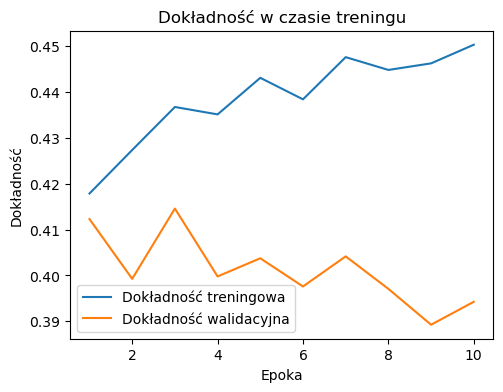

Test accuracy: 0.39741666666666664


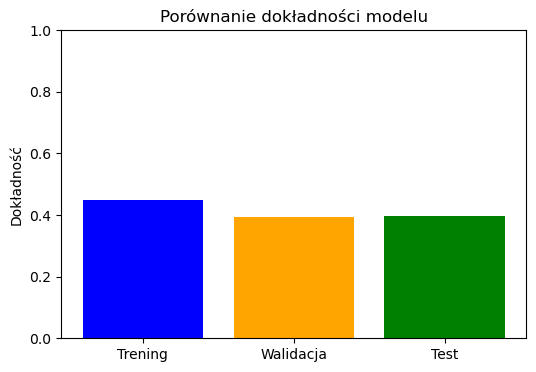

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning

# Wyłącz ostrzeżenia o konwergencji
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Załaduj dane CIFAR-10
cifar10 = fetch_openml('CIFAR_10', version=1, parser='auto')
X = cifar10.data
y = cifar10.target.astype(int)

# Podziel dane na zbiory treningowy, walidacyjny i testowy
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Przeskaluj dane
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Zdefiniuj model regresji logistycznej Softmax
log_reg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1, warm_start=True)

train_accuracies = []
val_accuracies = []
epochs = 10

# Trening modelu z wizualizacją postępu
for epoch in tqdm(range(epochs), desc="Trening regresji logistycznej"):
    log_reg.fit(X_train, y_train)
    train_accuracies.append(accuracy_score(y_train, log_reg.predict(X_train)))
    val_accuracies.append(accuracy_score(y_val, log_reg.predict(X_val)))

# Rysuj wykresy
plt.figure(figsize=(12, 4))

# Wykres dokładności
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracies, label='Dokładność treningowa')
plt.plot(range(1, epochs + 1), val_accuracies, label='Dokładność walidacyjna')
plt.title('Dokładność w czasie treningu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.show()

# Ocena modelu na zbiorze testowym
test_acc = accuracy_score(y_test, log_reg.predict(X_test))
print(f'Test accuracy: {test_acc}')

# Wykres porównania dokładności modelu na zbiorze treningowym, walidacyjnym i testowym
train_acc = train_accuracies[-1]
val_acc = val_accuracies[-1]

plt.figure(figsize=(6, 4))
plt.bar(['Trening', 'Walidacja', 'Test'], [train_acc, val_acc, test_acc], color=['blue', 'orange', 'green'])
plt.title('Porównanie dokładności modelu')
plt.ylabel('Dokładność')
plt.ylim(0, 1)
plt.show()


Natychmiast udało się osiągnąć prawie 40% dokładności. Spróbujemy jeszcze polepszyć wynik za pomocą regularyzacji oraz optymalizacji hiperparametrów. Regularyzacja polega na dodaniu do funkcji kosztu kary za duże wagi, co pozwala na uniknięcie overfittingu. Optymalizacja hiperparametrów polega na znalezieniu takich wartości hiperparametrów (np. learning rate, batch size, liczba epok), które pozwolą na uzyskanie najlepszego wyniku.

Teraz wykorzystamy do zdefiniowania modelu bibliotekę PyTorch, ponieważ dużo szybciej będzie uruchamiać się na GPU (scikit-learn nie obsługuje GPU, natomiast TensorFlow słabo obsługuje GPU na Windows).

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Training with parameters: batch_size=32, lr=0.001, l2=0.001
Training with parameters: batch_size=32, lr=0.01, l2=0.001
Training with parameters: batch_size=32, lr=0.001, l2=0.01
Training with parameters: batch_size=32, lr=0.01, l2=0.01
Training with parameters: batch_size=1024, lr=0.001, l2=0.001
Training with parameters: batch_size=1024, lr=0.01, l2=0.001
Training with parameters: batch_size=1024, lr=0.001, l2=0.01
Training with parameters: batch_size=1024, lr=0.01, l2=0.01
Best accuracy: 0.4103
Best parameters: {'batch_size': 1024, 'l2_regularization': 0.01, 'learning_rate': 0.001}


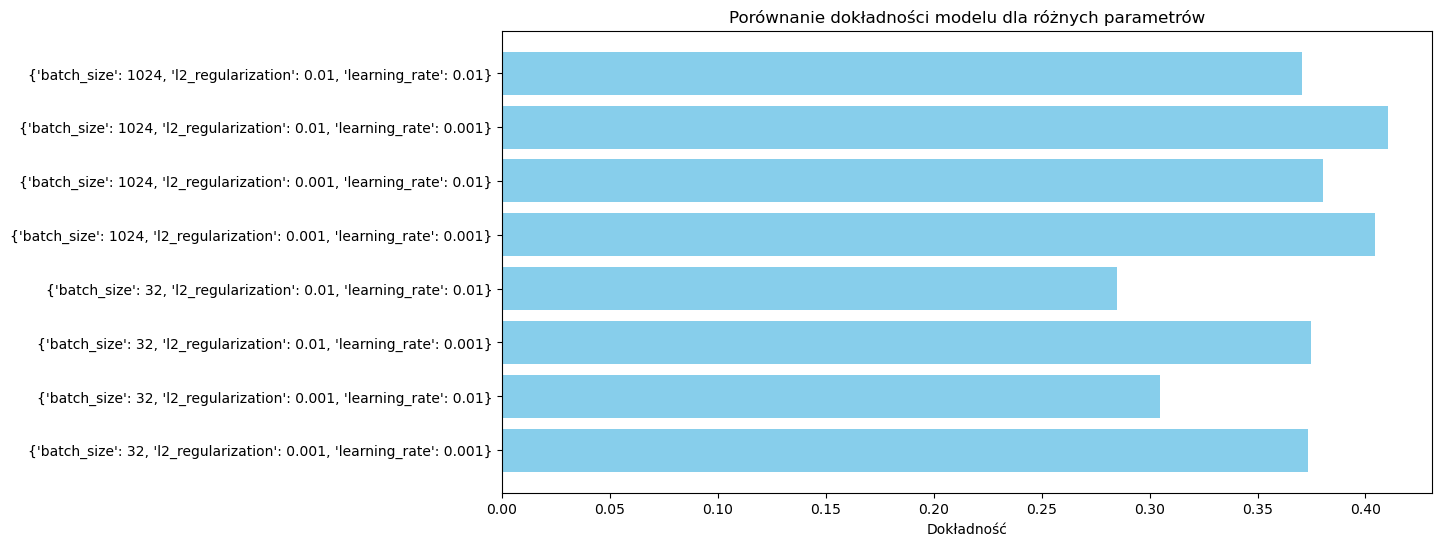

In [20]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from accelerate import Accelerator
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Użyj acceleratora
accelerator = Accelerator()

# Włącz tryb benchmark w cuDNN dla optymalnej wydajności
torch.backends.cudnn.benchmark = True

# Sprawdź urządzenie używane przez accelerator
print(f"Using device: {accelerator.device}")

# Definiuj transformacje dla zbioru danych CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Przygotuj zbiór danych CIFAR-10
train_dataset = datasets.CIFAR10(os.getcwd(), train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(os.getcwd(), train=False, download=True, transform=transform)

# Funkcja do tworzenia DataLoader
def create_dataloader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

# Definiuj model regresji Softmax
class SoftmaxRegression(nn.Module):
    def __init__(self):
        super(SoftmaxRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32*32*3, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Funkcja do trenowania modelu
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        current_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            accelerator.backward(loss)
            optimizer.step()
            current_loss += loss.item()

# Funkcja do testowania modelu
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Hiperparametry do optymalizacji
param_grid = {
    'batch_size': [32, 1024], 
    'learning_rate': [0.001, 0.01],
    'l2_regularization': [0.001, 0.01]
}

# Stała liczba epok
epochs = 10

# Optymalizuj hiperparametry
best_acc = 0
best_params = None
results = []

for params in ParameterGrid(param_grid):
    param_set = f"batch_size={params['batch_size']}, lr={params['learning_rate']}, l2={params['l2_regularization']}"
    print(f"Training with parameters: {param_set}")
    
    train_loader, test_loader = create_dataloader(params['batch_size'])
    
    model = SoftmaxRegression()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['l2_regularization'])
    
    # Przygotuj z accelerator
    model, optimizer, train_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, test_loader)
    
    train_model(model, train_loader, criterion, optimizer, epochs)
    acc = test_model(model, test_loader)
    
    results.append({
        'params': params,
        'final_accuracy': acc
    })
    
    if acc > best_acc:
        best_acc = acc
        best_params = params

    # Oczyść DataLoader aby zwolnić pamięć
    del train_loader
    del test_loader
    torch.cuda.empty_cache()  # Opróżnij pamięć GPU

print(f'Best accuracy: {best_acc}')
print(f'Best parameters: {best_params}')

# Wykres porównania dokładności modelu dla różnych parametrów
params_list = [str(result['params']) for result in results]
final_accuracies = [result['final_accuracy'] for result in results]

plt.figure(figsize=(12, 6))
plt.barh(params_list, final_accuracies, color='skyblue')
plt.xlabel('Dokładność')
plt.title('Porównanie dokładności modelu dla różnych parametrów')
plt.show()


Jak widać, bardziej optymalnym zestawem parametrów jest {'batch_size': 1024, 'l2_regularization': 0.01, 'learning_rate': 0.001}, lecz, mimo że udało nam się przekroczyć 40%, dokładność modelu pozostała na bardzo zbliżonym poziomie. Jak widać regresja nie pasuje do tego problemu, ponieważ nie jest w stanie wyodrębnić cech obrazów. Spróbujemy teraz zastosować inne modele.

### Drzewa decyzyjne

Drzewo decyzyjne to algorytm uczenia maszynowego oparty o uczenie nadzorowane. Może być używane do regresji, chociaż częściej jest używane do klasyfikacji. Drzewo decyzyjne posiada hierarchiczną strukturę drzewiastą.

![drzewo decyzyjne](images/decision.png)

Każde drzewo składa się z korzenia, gałęzi, węzłów decyzyjnych oraz liści.

#### Algorytm budowy (trenowania) drzewa decyzyjnego
Zakładamy, że mamy pary $(x_i, y_i)$ gdzie $x \in R^d$ należy do przestrzeni cech (atrybutów) oraz $y_i$ jest etykietą klasy.
1. Wybierz atrybut, który najlepiej dzieli dane. Przy wybieraniu atrybutu można się posłużyć wieloma miarami. Kilka z nich to:<br><br>
    1. <b>Zysk informacji:</b> Mierzy zmniejszenie entropii po podziale danych według danego atrybutu.
        &emsp;$IG(S,A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|}H(S_v)$ <br>
        &emsp;gdzie: <br>
            &emsp;&emsp;$H(S)$ - entropia na zbiorze S <br>
            &emsp;&emsp;$S_v$ - podzbiór danych w którym atrybut A ma wartość v <br><br>
    2. <b>Indeks Giniego:</b> Mierzy czystość zbioru danych po podziale według danego atrybutu. <br>
        &emsp;$Gini(S,A) = \sum_{v \in Values(A)} \frac{|S_v|}{|S|}Gini(S_v)$
        &emsp;gdzie: <br>
        &emsp;&emsp;$S_v$ - podzbiór danych w którym atrybut A ma wartość v <br><br>
dla każdego atrybutu obliczamy daną metrykę po podziale da


Drzewo decyzyjne może być binarne lub posiadać większą ilość gałęzi. Drzewo może mieć ograniczoną głębokość lub może być dzielone aż do momentu idealnej czystości węzła (wszystkie elementy należą do tej samej klasy) albo nie ma więcej atrybutów do podziału

Spróbujemy zbudować drzewo decyzyjne na zbiorze CIFAR-10:

Test accuracy: 0.26375


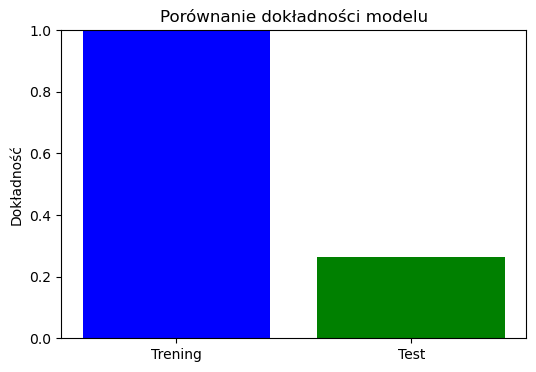

In [3]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Załaduj dane CIFAR-10
cifar10 = fetch_openml('CIFAR_10', version=1, parser='auto')
X = cifar10.data
y = cifar10.target.astype(int)

# Podziel dane na zbiory treningowy, walidacyjny i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Przeskaluj dane
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Zdefiniuj model drzewa decyzyjnego
tree_clf = DecisionTreeClassifier(random_state=42)

# Trening modelu
tree_clf.fit(X_train, y_train)

# Ocena modelu na zbiorze treningowym
train_acc = accuracy_score(y_train, tree_clf.predict(X_train))

# Ocena modelu na zbiorze testowym
test_acc = accuracy_score(y_test, tree_clf.predict(X_test))
print(f'Test accuracy: {test_acc}')

# Wykres porównania dokładności modelu na zbiorze treningowym i testowym
plt.figure(figsize=(6, 4))
plt.bar(['Trening', 'Test'], [train_acc, test_acc], color=['blue', 'green'])
plt.title('Porównanie dokładności modelu')
plt.ylabel('Dokładność')
plt.ylim(0, 1)
plt.show()


Jak widać, dla dla danych uczących model osiąga 100% dokładności, natomiast dla danych testowych dokładność wynosi około 30%. To oznacza, że model jest zbyt skomplikowany i doszło do overfittingu. Spróbujemy teraz zastosować przycinanie drzewa decyzyjnego. Możemy spróbować dostosować parametry uczenia, żeby drzewo było w miarę jednorodne oraz nie miało bardzo długich gałęzi.

Train accuracy: 0.4234583333333333
Test accuracy: 0.30183333333333334


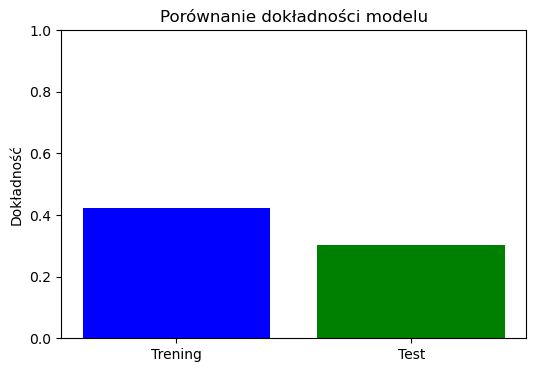

In [6]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Załaduj dane CIFAR-10
cifar10 = fetch_openml('CIFAR_10', version=1, parser='auto')
X = cifar10.data
y = cifar10.target.astype(int)

# Podziel dane na zbiory treningowy, walidacyjny i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Przeskaluj dane
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Zdefiniuj model drzewa decyzyjnego z przycinaniem
tree_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)

# Trening modelu
tree_clf.fit(X_train, y_train)

# Ocena modelu na zbiorze treningowym
train_acc = accuracy_score(y_train, tree_clf.predict(X_train))

# Ocena modelu na zbiorze testowym
test_acc = accuracy_score(y_test, tree_clf.predict(X_test))
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

# Wykres porównania dokładności modelu na zbiorze treningowym i testowym
plt.figure(figsize=(6, 4))
plt.bar(['Trening', 'Test'], [train_acc, test_acc], color=['blue', 'green'])
plt.title('Porównanie dokładności modelu')
plt.ylabel('Dokładność')
plt.ylim(0, 1)
plt.show()


Widzimy, że dostrajanie hyperparametrów mocno wpłynęło na overfitting, natomiast dokładność modelu wciąż jest niska. Jeszcze jednym sposobem na poprawę wyników, przy utrzymaniu podobnej architektury, jest zastosowanie lasów losowych, czyli zespołu drzew decyzyjnych.

### Lasy losowe

Train accuracy: 0.975875
Test accuracy: 0.4588333333333333


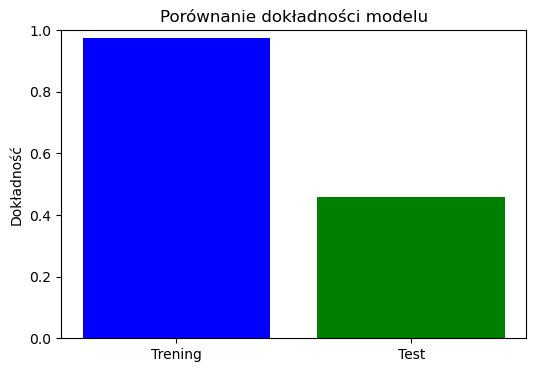

In [7]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Załaduj dane CIFAR-10
cifar10 = fetch_openml('CIFAR_10', version=1, parser='auto')
X = cifar10.data
y = cifar10.target.astype(int)

# Podziel dane na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Przeskaluj dane
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Zdefiniuj model Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=10, min_samples_leaf=5, random_state=42, n_jobs=-1)

# Trening modelu
rf_clf.fit(X_train, y_train)

# Ocena modelu na zbiorze treningowym
train_acc = accuracy_score(y_train, rf_clf.predict(X_train))

# Ocena modelu na zbiorze testowym
test_acc = accuracy_score(y_test, rf_clf.predict(X_test))
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

# Wykres porównania dokładności modelu na zbiorze treningowym i testowym
plt.figure(figsize=(6, 4))
plt.bar(['Trening', 'Test'], [train_acc, test_acc], color=['blue', 'green'])
plt.title('Porównanie dokładności modelu')
plt.ylabel('Dokładność')
plt.ylim(0, 1)
plt.show()


Dostaliśmy przyrost o kolejne 10%, natomiast rzuca się w oczy tendencja modelu do overfittingu. Niemniej jednak, jest to bardzo uniwersalny model, który dobrze radzi sobie z różnymi problemami klasyfikacji.

### Maszyny Wektorów Nośnych

Maszyny wektorów nośnych (SVM) to algorytm uczenia maszynowego, który jest używany zarówno do klasyfikacji jak i regresji. W przypadku klasyfikacji SVM znajduje hiperpłaszczyznę, która najlepiej dzieli dane na dwie klasy. W przypadku regresji SVM znajduje hiperpłaszczyznę, która najlepiej pasuje do danych.

Użyjemy SVM do klasyfikacji obrazów z CIFAR-10. Ze względu na dużą ilość danych, zastosujemy redukcję wymiarowości za pomocą PCA oraz wykorzysamy tylko podzbiór danych do trenowania. PCA jest dobrą metodą do redukcji wymiarowości, ponieważ pozwala na zachowanie jak największej ilości wariancji w danych.

Train accuracy: 0.6666666666666666
Test accuracy: 0.4335833333333333


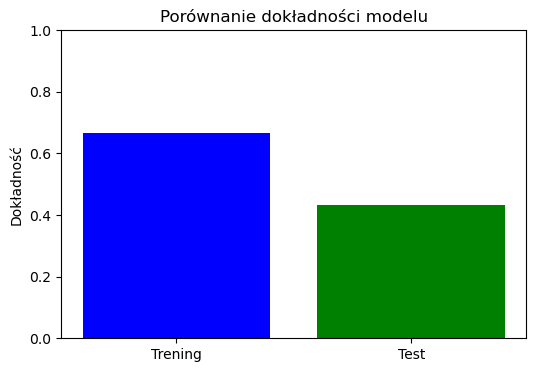

In [5]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Załaduj dane CIFAR-10
cifar10 = fetch_openml('CIFAR_10', version=1, parser='auto')
X = cifar10.data
y = cifar10.target.astype(int)

# Podziel dane na zbiory treningowy i testowy
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Użyj tylko małej części danych do szybkiego trenowania
X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=0.1, random_state=42)

# Przeskaluj dane
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Zastosuj PCA do redukcji wymiarowości
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Zdefiniuj model SVM
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Trening modelu
svm_clf.fit(X_train_pca, y_train)

# Ocena modelu na zbiorze treningowym
train_acc = accuracy_score(y_train, svm_clf.predict(X_train_pca))

# Ocena modelu na zbiorze testowym
test_acc = accuracy_score(y_test, svm_clf.predict(X_test_pca))
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

# Wykres porównania dokładności modelu na zbiorze treningowym i testowym
plt.figure(figsize=(6, 4))
plt.bar(['Trening', 'Test'], [train_acc, test_acc], color=['blue', 'green'])
plt.title('Porównanie dokładności modelu')
plt.ylabel('Dokładność')
plt.ylim(0, 1)
plt.show()


### Algorytm KNN

KNN to prosty algorytm uczenia maszynowego wykorzystywany głównie do klasyfikacji, chociaż może być wykorzystany również do regresji. Główną ideę algorytmu można opisać następująco: dla danej próby znajdź k najbliższych elementów w zbiorze treningowym wykorzystując podaną metrykę. Klasa, która jest najbardziej liczna w wybranym podzbiorze jest wynikiem klasyfikacji.

#### Kroki algorytmu
1. Zdefiniuj przestrzeń cech $R^{d}$, etykiety klas $Y=\{y_1, y_2, ..., y_n\}$ oraz parametr $k \in \mathbb{N}$.
2. Podaj zbiór par cecha-etykieta $(X_i,y_i)$.
3. Wybierz normę $||\cdot||$ na $R^{d}$ .
4. Wtedy funkcja $f: R^{d} \mapsto Y$, $ f(x) =  mode(\{y_i: i \leq k\})$ gdzie dla $x \in R^d$ oznaczamy $(X_1, y_1), (X_2, y_2) ... (X_n, y_n)$ tak że $||X_1 - x|| \leq ... \leq ||X_n - x||$ oraz $mode()$ oznacza wybranie elementu najczęściej powtarzającego się.
5. Wtedy predykcja dla $x$ to $f(x)$.

![knn2](images/knn2.png)

Algorytm KNN zakłada, że dane znajdujące się w tej samej klasie mają podobne cechy do siebie nawzajem podczas gdy dane z różnych klas mają cechy znacznie różniące się od siebie.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np


# Load CIFAR-10 dataset
cifar10 = fetch_openml('CIFAR_10', version=1, parser='auto')
X = cifar10.data
y = cifar10.target.astype(int)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = [np.array(t) for t in train_test_split(X, y, test_size=0.2, random_state=42)]

knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier.fit(x_train.reshape(x_train.shape[0], -1), y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(x_test.reshape(x_test.shape[0], -1))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.338


Aby polepszyć wyniki możemy przeskalować wymiary cech tak aby odległość w każdym wymiarze miała równy wpływ na wynik klasyfikacji niezależnie od wariancji danych w tym wymiarze.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

knn_classifier_unscaled = KNeighborsClassifier(n_neighbors=5)
scaler = StandardScaler()

knn_classifier_scaled = Pipeline([
    ('scaler', scaler),  # Add scaler step
    ('classifier', knn_classifier_unscaled)  # Add classifier step
])

# Train the classifier
knn_classifier_scaled.fit(x_train.reshape(x_train.shape[0], -1), y_train)

# Make predictions on the test set
y_pred = knn_classifier_scaled.predict(x_test.reshape(x_test.shape[0], -1))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.33766666666666667


Jak widać akurat w tym przypadku skalowanie nie wpływa znacząco na wynik.

#### Krzywa ROC

Możemy obliczyć wynik ROC oraz AUC.

Krzywa ROC to krzywa, która pokazuje stosunek między prawdziwie pozytywnymi a fałszywie pozytywnymi wynikami klasyfikacji. AUC to pole pod krzywą ROC. Im większe AUC tym lepszy model.

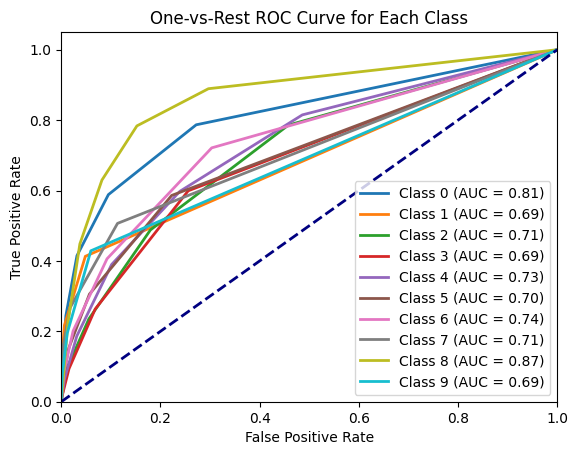

In [6]:
from sklearn.metrics import roc_curve, auc

sample_size = 10000

plt.figure()
x_test_sample, y_test_sample = x_test.reshape(x_test.shape[0], -1)[0:sample_size], y_test.flatten()[0:sample_size]
# Iterate over each class
for i in range(10):  # 10 classes
    # Convert multiclass labels to binary labels for the selected class
    y_binary = np.array([1 if label == i else 0 for label in y_test_sample])
    
    # Predict probabilities for the selected class
    y_scores = knn_classifier_scaled.predict_proba(x_test_sample)[:, i]  # Probability for class i
    
    # Compute ROC curve and AUC for the selected class
    fpr, tpr, thresholds = roc_curve(y_binary, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the selected class
    plt.plot(fpr, tpr, lw=2, label='Class {} (AUC = {:.2f})'.format(i, roc_auc))

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

#### Krzywa uczenia


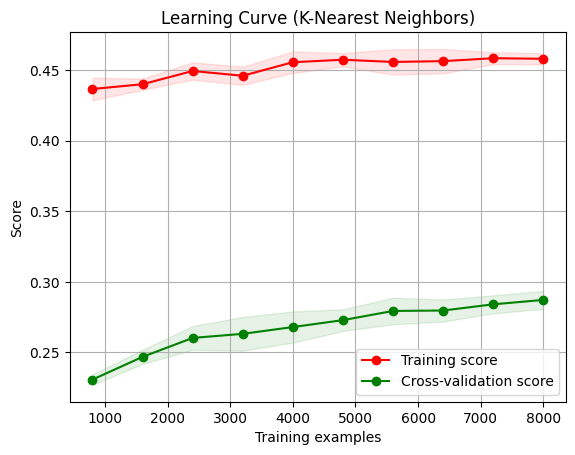

In [122]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_classifier_scaled,
    X=x_test_sample,
    y=y_test_sample,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.title("Learning Curve (K-Nearest Neighbors)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

Jak widać w klasyfikatorze KNN nie dochodzi do overfittingu na zbiorze cifar10.

Jak można było przypuszczać, klasyfikator KNN niezbyt dobrze sobie radzi na zbiorze cifar10. Można przypuszczać, że jest tak ponieważ relacje pomiędzy zdjęciami są zbyt skomplikowane aby po prostu obliczać odległość pomiędzy pikselami.

## Uczenie głębokie

### MLP perceptron

Perceptron stanowi jedną z najprostszych architektur sieci neuronowej, zaproponowaną w 1957 roku przez Franka Rosenblatta. Jego podstawą jest nieco zmodyfikowany sztuczny neuron, zwany progową jednostką logiczną (ang. *Threshold Logic Unit* — TLU) lub liniową jednostką progową (ang. *Linear Threshold Unit* — LTU). Wartościami wejść/wyjść są liczby (a nie stany binarne), a każde połączenie ma przyporządkowaną wagę. Jednostka TLU wylicza ważoną sumę sygnałów wejściowych $z = w_1 x_1 + w_2 x_2 + \ldots + w_n x_n = x^T w$, a następnie zostaje użyta funkcja skokowa wobec tej sumy, dająca ostateczny wynik: $h_w(x) = \text{skok}(z)$, gdzie $z = x^T w$.

![Perceptron](images/mlp1.png)

Spóbujemy nauczyć perceptron klasyfikować dane CIFAR-10:


Trening perceptronu: 100%|██████████| 10/10 [02:08<00:00, 12.84s/it]


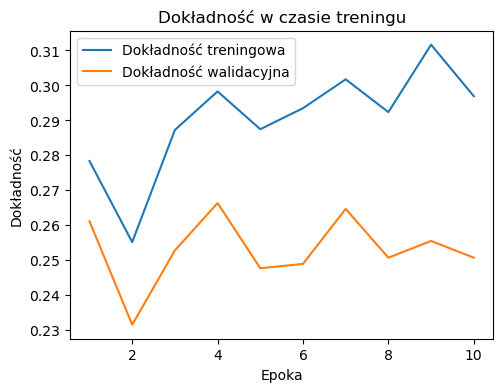

Test accuracy (Perceptron): 0.2554166666666667


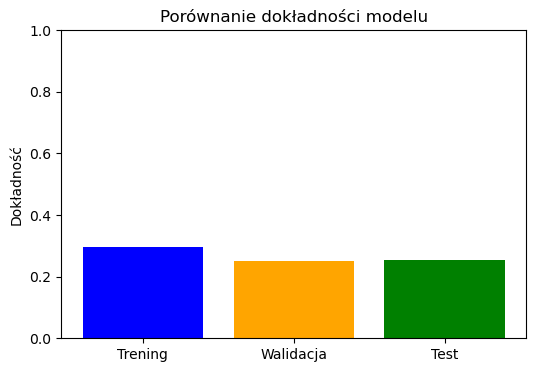

In [16]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning

# Wyłącz ostrzeżenia o konwergencji
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Załaduj dane CIFAR-10
cifar10 = fetch_openml('CIFAR_10', version=1, parser='auto')
X = cifar10.data
y = cifar10.target.astype(int)

# Podziel dane na zbiory treningowy, walidacyjny i testowy
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Przeskaluj dane
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Zbuduj perceptron
perceptron = Perceptron(max_iter=1, tol=None, random_state=42, warm_start=True)

# Funkcja pomocnicza do wyświetlania wyników treningu
def plot_training_history(train_accuracies, val_accuracies):
    # Wykres dokładności
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Dokładność treningowa')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Dokładność walidacyjna')
    plt.title('Dokładność w czasie treningu')
    plt.xlabel('Epoka')
    plt.ylabel('Dokładność')
    plt.legend()

    plt.show()

# Trening perceptronu z wizualizacją postępu
train_accuracies = []
val_accuracies = []
epochs = 10

for epoch in tqdm(range(epochs), desc="Trening perceptronu"):
    perceptron.fit(X_train, y_train)
    train_accuracies.append(accuracy_score(y_train, perceptron.predict(X_train)))
    val_accuracies.append(accuracy_score(y_val, perceptron.predict(X_val)))

# Wykresy
plot_training_history(train_accuracies, val_accuracies)

# Ocena perceptronu na zbiorze testowym
test_acc = accuracy_score(y_test, perceptron.predict(X_test))
print(f'Test accuracy (Perceptron): {test_acc}')

# Wykres porównania dokładności modelu na zbiorze treningowym, walidacyjnym i testowym
train_acc = train_accuracies[-1]
val_acc = val_accuracies[-1]

plt.figure(figsize=(6, 4))
plt.bar(['Trening', 'Walidacja', 'Test'], [train_acc, val_acc, test_acc], color=['blue', 'orange', 'green'])
plt.title('Porównanie dokładności modelu')
plt.ylabel('Dokładność')
plt.ylim(0, 1)
plt.show()


Wynik jest bardzo niski, co nie jest zaskoczeniem.

Perceptron jest w stanie rozwiązać jedynie problemy liniowo separowalne, czyli takie, w których istnieje płaszczyzna (dla dwóch wymiarów) lub hiperpłaszczyzna (dla większej liczby wymiarów), która oddziela dane z różnych klas. W przypadku, gdy dane nie są liniowo separowalne, perceptron nie jest w stanie nauczyć się poprawnie klasyfikować danych. W takim przypadku stosuje się bardziej zaawansowane architektury sieci neuronowych, takie jak wielowarstwowe perceptrony (MLP).

![Xor](images/mlp2.png)

MLP składa się z co najmniej trzech warstw: warstwy wejściowej, warstwy wyjściowej oraz jednej lub więcej warstw ukrytych. Każda warstwa składa się z wielu neuronów, które są połączone z neuronami z sąsiednich warstw. Wagi połączeń między neuronami są inicjalizowane losowo, a następnie są aktualizowane w procesie uczenia. Wagi te są aktualizowane w taki sposób, aby minimalizować funkcję kosztu, np. błąd średniokwadratowy.

![MLP](images/mlp3.png)

Zobaczymy jak poradzi sobie MLP na zbiorze CIFAR-10:


Trening MLP: 100%|██████████| 10/10 [02:42<00:00, 16.25s/it]


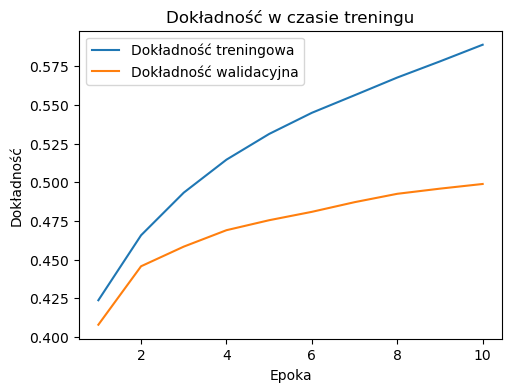

Test accuracy (MLP): 0.49616666666666664


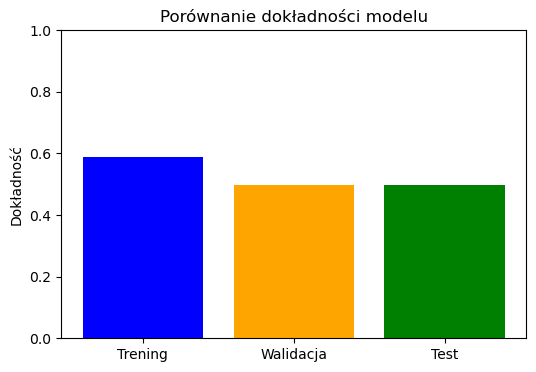

In [17]:
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning

# Wyłącz ostrzeżenia o konwergencji
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Zdefiniuj MLP z optymalizatorem adam
mlp = MLPClassifier(hidden_layer_sizes=(512,), max_iter=1, solver='sgd', warm_start=True, random_state=42)

train_accuracies_mlp = []
val_accuracies_mlp = []

# Trening MLP z wizualizacją postępu
epochs = 10
for epoch in tqdm(range(epochs), desc="Trening MLP"):
    mlp.fit(X_train, y_train)
    train_accuracies_mlp.append(accuracy_score(y_train, mlp.predict(X_train)))
    val_accuracies_mlp.append(accuracy_score(y_val, mlp.predict(X_val)))

# Wykres dokładności
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies_mlp) + 1), train_accuracies_mlp, label='Dokładność treningowa')
plt.plot(range(1, len(val_accuracies_mlp) + 1), val_accuracies_mlp, label='Dokładność walidacyjna')
plt.title('Dokładność w czasie treningu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.show()

# Ocena MLP na zbiorze testowym
test_acc_mlp = accuracy_score(y_test, mlp.predict(X_test))
print(f'Test accuracy (MLP): {test_acc_mlp}')

# Wykres porównania dokładności modelu na zbiorze treningowym, walidacyjnym i testowym
train_acc_mlp = train_accuracies_mlp[-1]
val_acc_mlp = val_accuracies_mlp[-1]

plt.figure(figsize=(6, 4))
plt.bar(['Trening', 'Walidacja', 'Test'], [train_acc_mlp, val_acc_mlp, test_acc_mlp], color=['blue', 'orange', 'green'])
plt.title('Porównanie dokładności modelu')
plt.ylabel('Dokładność')
plt.ylim(0, 1)
plt.show()


Bardzo szybko udało się osiągnąć wynik na poziomie 50%. W przypadku CIFAR-10, dane są zbyt skomplikowane, aby perceptron mógł się nauczyć poprawnie klasyfikować obrazy. MLP, dzięki warstwie ukrytej, jest w stanie nauczyć się bardziej złożonych zależności między danymi.

Gdy mamy więcej niż jedną warstwę ukrytą, taką architekturę nazywamy głęboką siecią neuronową. W przypadku sieci neuronowych z jedną warstwą ukrytą mówimy o sieciach płytkich. Sieci głębokie są w stanie modelować bardziej złożone zależności między danymi, co pozwala na uzyskanie lepszych wyników w zadaniach uczenia maszynowego.

### Sieć neuronowa (Deep Neural Network — DNN)

Przez wiele lat próbowano znaleźć sposób na nauczenie sieci neuronowych. Dopiero w 1986 roku David Rumelhart, Geoffrey Hinton i Ronald Williams zaproponowali algorytm wstecznej propagacji błędu, który pozwolił na efektywne uczenie sieci neuronowych. Wtedy też zaczęto mówić o głębokich sieciach neuronowych.

Do tej pory wynaleziono wiele różnych sposobów optymalizacji uczenia sieci neuronowych: augmentacje danych, porzucenie neuronów dropout, normalizacja wsadowa, różne funkcje aktywacji, funkcje kosztu, optymalizatory, itp. Dostępne są również wielorakie algorytmy różniczowania automatycznego, które pozwalają na obliczanie gradientów funkcji kosztu w sposób automatyczny.

Spróbujemy teraz zastosować wielowarstwową sieć neuronową z wymienionymi technikami optymalizacji do klasyfikacji CIFAR-10.


Epoch 1/10
157/157 [==============================] - 5s 24ms/step - loss: 2.4068 - accuracy: 0.2608 - val_loss: 1.8310 - val_accuracy: 0.3885
Epoch 2/10
157/157 [==============================] - 4s 23ms/step - loss: 1.8775 - accuracy: 0.3449 - val_loss: 1.6150 - val_accuracy: 0.4215
Epoch 3/10
157/157 [==============================] - 4s 22ms/step - loss: 1.6988 - accuracy: 0.3954 - val_loss: 1.5451 - val_accuracy: 0.4492
Epoch 4/10
157/157 [==============================] - 4s 23ms/step - loss: 1.6043 - accuracy: 0.4244 - val_loss: 1.4779 - val_accuracy: 0.4696
Epoch 5/10
157/157 [==============================] - 4s 23ms/step - loss: 1.5551 - accuracy: 0.4426 - val_loss: 1.4502 - val_accuracy: 0.4849
Epoch 6/10
157/157 [==============================] - 4s 23ms/step - loss: 1.5104 - accuracy: 0.4574 - val_loss: 1.4226 - val_accuracy: 0.4930
Epoch 7/10
157/157 [==============================] - 4s 23ms/step - loss: 1.4757 - accuracy: 0.4716 - val_loss: 1.3957 - val_accuracy: 0.4998

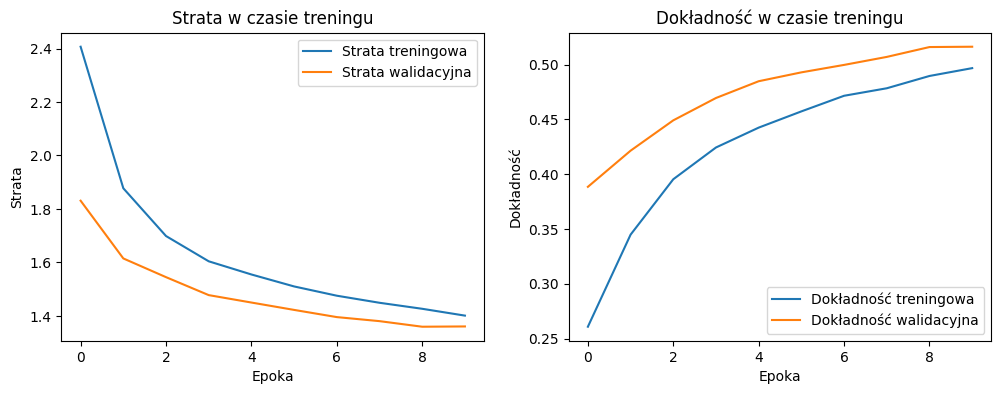

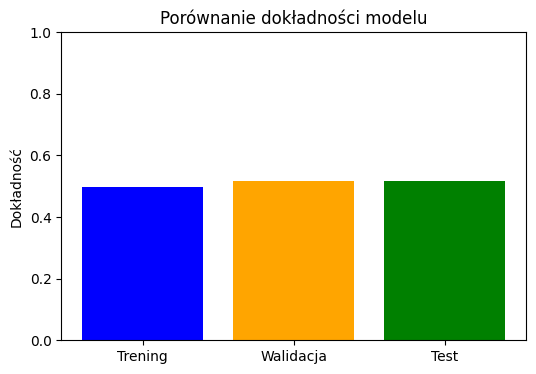

In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import matplotlib.pyplot as plt

# Załaduj dane CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Przeskaluj dane
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Normalizacja
normalizer = Normalization()
normalizer.adapt(X_train)

X_train = normalizer(X_train)
X_test = normalizer(X_test)

# One-hot encoding etykiet
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Definiuj uproszczony model z dropout i batch normalization
model = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(512),
    Activation('gelu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512),
    Activation('gelu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512),
    Activation('gelu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Kompiluj model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.2)

# Ocena modelu
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Wykresy straty i dokładności
plt.figure(figsize=(12, 4))

# Wykres straty
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata w czasie treningu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność w czasie treningu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.show()

# Wykres porównania dokładności modelu na zbiorze treningowym i testowym
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

plt.figure(figsize=(6, 4))
plt.bar(['Trening', 'Walidacja', 'Test'], [train_acc, val_acc, test_acc], color=['blue', 'orange', 'green'])
plt.title('Porównanie dokładności modelu')
plt.ylabel('Dokładność')
plt.ylim(0, 1)
plt.show()


Na reszcie udało nam się przekroczyć 50% dokładności. Wciąż brakuje jednak pewnej specjalizacji modelu do celów widzenia komputerowego. Zamiast wektorów będących znormalizowanymi wartościami pikseli, moglibyśmy tak naprawdę wgrać do sieci dowolne inne dane. I chociaż wynik jest powyżej przeciętnego, potrzebny jest sposób na powiązanie tej ambitnej architektury z naturą obrazów. Jak często bywa w nauce, odpowiedź na to pytanie została odnaleziona w przyrodzie.

### CNN – Konwolucyjna sieć neuronowa od zera

Konwolucyjne sieci neuronowe (CNN) są jednym z najpopularniejszych modeli do klasyfikacji obrazów. Składają się z warstw konwolucyjnych, warstw poolingowych oraz warstw w pełni połączonych. Warstwy konwolucyjne służą do wykrywania cech w obrazie, warstwy poolingowe do zmniejszania wymiarowości obrazu, a warstwy w pełni połączone do klasyfikacji. Ta architektura była zainspirowana budową kory wzrokowej człowieka.

![KNN1](images/knn1.png)

W naszym przypadku zbudujemy prostą sieć z jedną warstwą konwolucyjną, jedną warstwą poolingową oraz jedną warstwą w pełni połączoną. Na końcu dodamy funkcję aktywacji Softmax, która zwróci prawdopodobieństwa przynależności do każdej z klas.

Następnie spróbujemy dodać więcej warstw i porównamy wyniki.

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
[simple_cnn] Epoch [1/10] Loss: 1.4374, Val Accuracy: 0.5585
[simple_cnn] Epoch [2/10] Loss: 1.1640, Val Accuracy: 0.5912
[simple_cnn] Epoch [3/10] Loss: 1.0450, Val Accuracy: 0.6190
[simple_cnn] Epoch [4/10] Loss: 0.9616, Val Accuracy: 0.6302
[simple_cnn] Epoch [5/10] Loss: 0.9054, Val Accuracy: 0.6358
[simple_cnn] Epoch [6/10] Loss: 0.8595, Val Accuracy: 0.6423
[simple_cnn] Epoch [7/10] Loss: 0.8220, Val Accuracy: 0.6373
[simple_cnn] Epoch [8/10] Loss: 0.7915, Val Accuracy: 0.6376
[simple_cnn] Epoch [9/10] Loss: 0.7608, Val Accuracy: 0.6475
[simple_cnn] Epoch [10/10] Loss: 0.7325, Val Accuracy: 0.6484
Accuracy of the simple CNN on the test images: 64.73%


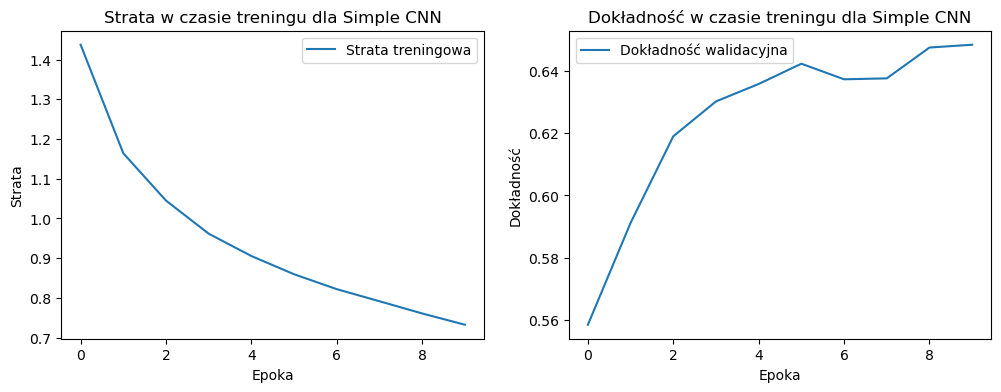

In [30]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from accelerate import Accelerator
import matplotlib.pyplot as plt

# Użyj acceleratora
accelerator = Accelerator()

# Włącz tryb benchmark w cuDNN dla optymalnej wydajności
torch.backends.cudnn.benchmark = True

# Sprawdź urządzenie używane przez accelerator
print(f"Using device: {accelerator.device}")

# Definiuj transformacje dla zbioru danych CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Przygotuj zbiór danych CIFAR-10
dataset = datasets.CIFAR10(os.getcwd(), train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(os.getcwd(), train=False, download=True, transform=transform)

# Podziel zbiór danych na treningowy i walidacyjny
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Funkcja do tworzenia DataLoader
def create_dataloader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    return train_loader, val_loader, test_loader

# Definiuj prostą sieć CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 16 * 16, 10)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc1(x)
        return x

# Funkcja do trenowania modelu
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, param_set, train_losses, val_accuracies):
    model.train()
    for epoch in range(epochs):
        current_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            accelerator.backward(loss)
            optimizer.step()
            current_loss += loss.item()
        train_losses.append(current_loss / len(train_loader))
        val_acc = validate_model(model, val_loader)
        val_accuracies.append(val_acc)
        print(f'[{param_set}] Epoch [{epoch + 1}/{epochs}] Loss: {current_loss / len(train_loader):.4f}, Val Accuracy: {val_acc:.4f}')

# Funkcja do walidacji modelu
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Funkcja do testowania modelu
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Hiperparametry
batch_size = 64
learning_rate = 0.001
epochs = 10

# Inicjalizuj model
train_loader, val_loader, test_loader = create_dataloader(batch_size)
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Przygotuj z accelerator
model, optimizer, train_loader, val_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, val_loader, test_loader)

train_losses = []
val_accuracies = []

# Trenuj model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs, "simple_cnn", train_losses, val_accuracies)

# Oceń model
accuracy = test_model(model, test_loader)
print(f'Accuracy of the simple CNN on the test images: {accuracy * 100:.2f}%')

# Wizualizacja wyników
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Strata treningowa')
plt.title('Strata w czasie treningu dla Simple CNN')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Dokładność walidacyjna')
plt.title('Dokładność w czasie treningu dla Simple CNN')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.show()


Widać, że ten model ma duży potencjał - nawet w podstawowej wersji osiągnął wynik 65% dokładności. Spróbujemy teraz zbudować bardziej zaawansowany model.

[extended_cnn] Epoch [1/10] Loss: 1.4154, Val Accuracy: 0.5997
[extended_cnn] Epoch [2/10] Loss: 0.9591, Val Accuracy: 0.6758
[extended_cnn] Epoch [3/10] Loss: 0.7687, Val Accuracy: 0.7047
[extended_cnn] Epoch [4/10] Loss: 0.6043, Val Accuracy: 0.7136
[extended_cnn] Epoch [5/10] Loss: 0.4460, Val Accuracy: 0.7192
[extended_cnn] Epoch [6/10] Loss: 0.2942, Val Accuracy: 0.7318
[extended_cnn] Epoch [7/10] Loss: 0.1803, Val Accuracy: 0.7197
[extended_cnn] Epoch [8/10] Loss: 0.0999, Val Accuracy: 0.7269
[extended_cnn] Epoch [9/10] Loss: 0.0751, Val Accuracy: 0.7247
[extended_cnn] Epoch [10/10] Loss: 0.0714, Val Accuracy: 0.7217
Accuracy of the extended CNN on the test images: 71.80%


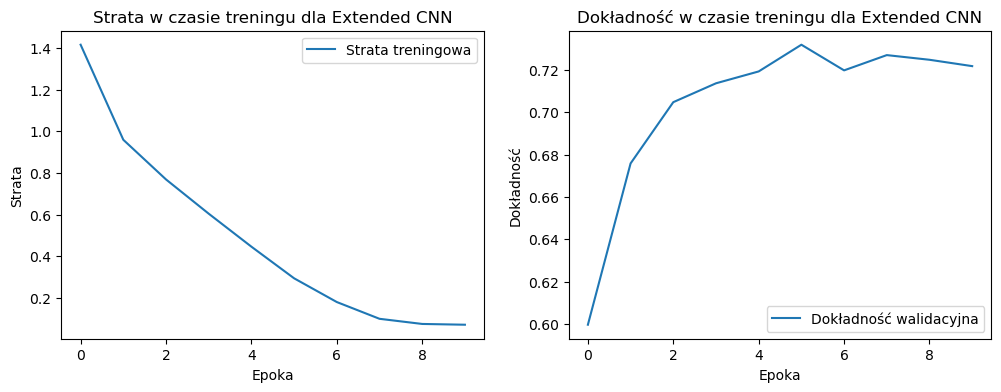

In [19]:
# Definiuj rozszerzoną sieć CNN
class ExtendedCNN(nn.Module):
    def __init__(self):
        super(ExtendedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Hiperparametry
batch_size = 64
learning_rate = 0.001
epochs = 10

# Inicjalizuj model
train_loader, val_loader, test_loader = create_dataloader(batch_size)
model = ExtendedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Przygotuj z accelerator
model, optimizer, train_loader, val_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, val_loader, test_loader)

train_losses = []
val_accuracies = []

# Trenuj model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs, "extended_cnn", train_losses, val_accuracies)

# Oceń model
accuracy = test_model(model, test_loader)
print(f'Accuracy of the extended CNN on the test images: {accuracy * 100:.2f}%')

# Wizualizacja wyników
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Strata treningowa')
plt.title('Strata w czasie treningu dla Extended CNN')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Dokładność walidacyjna')
plt.title('Dokładność w czasie treningu dla Extended CNN')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.show()


Teraz stało się oczywiste czemu architektura CNN stała się przedmiotem intensywnych badań w dziedzinie widzenia komputerowego. Bez zbytnich komplikacji udało się osiągnąć wynik 72% dokładności. Okazuje się, że przy wystarczająco dużej ilości warstw oraz odpowiednich hiperparametrach, CNN potrafi osiągnąć wyniki porównywalne z ludźmi. Jeszce lepsze wyniki wykazuje modyfikacja CNN, czyli sieć ResNet (sieć rezydualna).

## Modele SOTA (State Of The Art) 

### ResNet


Sieci rezydualne (ResNet) to rodzina sieci neuronowych, które pozwalają na trenowanie bardzo głębokich modeli. W przeciwieństwie do zwykłych sieci neuronowych, w których informacje przepływają sekwencyjnie, w ResNet informacje przepływają za pomocą skoków z jednej warstwy do innej. Dzięki temu unikamy problemu zanikającego gradientu, który pojawia się w bardzo głębokich sieciach.

![ResNet](images/resnet1.png)

Zastosujemy model ResNet50, który składa się z 50 warstw. Wytrenujemy go na zbiorze CIFAR-10 (tzw. fine-tuning, kiedy zmieniane są tylko ostatnie warstwy) i porównamy wyniki z poprzednimi modelami.



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10] Loss: 0.6224, Val Accuracy: 0.8856
Epoch [2/10] Loss: 0.2986, Val Accuracy: 0.8828
Epoch [3/10] Loss: 0.1516, Val Accuracy: 0.8767
Early stopping
Zapisano wytrenowany model.


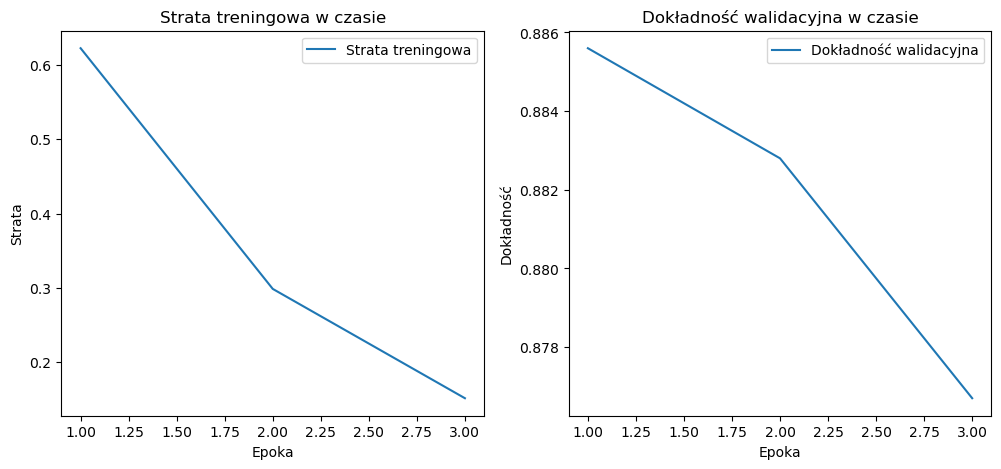

Accuracy of fine-tuned ResNet on the test images: 87.48%


In [40]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from accelerate import Accelerator
import matplotlib.pyplot as plt

# Inicjalizuj accelerator
accelerator = Accelerator()

# Definiuj transformacje dla zbioru danych CIFAR-10
transform = transforms.Compose([
    transforms.Resize(224),  # Zmień rozmiar, aby dopasować do wejścia modelu
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Przygotuj zbiór danych CIFAR-10
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Podziel zbiór danych na treningowy i walidacyjny
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Funkcja do tworzenia DataLoader
def create_dataloader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    return train_loader, val_loader, test_loader

# Załaduj wstępnie wytrenowany model ResNet z timm i zmodyfikuj go dla CIFAR-10
model = timm.create_model('resnet50', pretrained=True, num_classes=10)

# Zamroź początkowe warstwy
for name, param in model.named_parameters():
    if "layer4" not in name:  # Odblojuj tylko ostatni blok
        param.requires_grad = False

# Definiuj funkcję straty i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Stwórz DataLoader'y
batch_size = 64
train_loader, val_loader, test_loader = create_dataloader(batch_size)

# Przygotuj z accelerator
model, optimizer, train_loader, val_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, val_loader, test_loader)

# Funkcja do trenowania modelu z wczesnym zatrzymaniem
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    model.train()
    train_losses = []
    val_accuracies = []
    best_val_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        current_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            accelerator.backward(loss)
            optimizer.step()
            current_loss += loss.item()
        
        avg_loss = current_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_acc = validate_model(model, val_loader)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch + 1}/{epochs}] Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        # Wczesne zatrzymanie
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            patience_counter = 0
            # Zapisz najlepszy model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping")
            break

    return train_losses, val_accuracies

# Funkcja do walidacji modelu
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Funkcja do testowania modelu
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Parametry treningu
epochs = 10
patience = 2  # Liczba epok do wczesnego zatrzymania, jeśli nie ma poprawy

# Ścieżka do zapisywania/wczytywania wag modelu
model_path = 'resnet_cifar10.pth'

# Sprawdź, czy istnieje zapisany model
if os.path.exists(model_path):
    # Wczytaj zapisany model
    model.load_state_dict(torch.load(model_path, map_location=accelerator.device))
    print("Wczytano zapisany model.")
else:
    # Trenuj model
    train_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience)
    # Zapisz wagi modelu
    torch.save(model.state_dict(), model_path)
    print("Zapisano wytrenowany model.")
    
    # Wykresy
    plt.figure(figsize=(12, 5))

    # Wykres strat treningowych
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Strata treningowa')
    plt.xlabel('Epoka')
    plt.ylabel('Strata')
    plt.title('Strata treningowa w czasie')
    plt.legend()

    # Wykres dokładności walidacyjnej
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Dokładność walidacyjna')
    plt.xlabel('Epoka')
    plt.ylabel('Dokładność')
    plt.title('Dokładność walidacyjna w czasie')
    plt.legend()

    plt.show()

# Oceń model
accuracy = test_model(model, test_loader)
print(f'Accuracy of fine-tuned ResNet on the test images: {accuracy * 100:.2f}%')


Jak widać, już po pierwszej epoce udało się osiągnąć wynik 88% dokładności na zbiorze walidacyjnym, oraz 87% na zbiorze testowym po 3 epokach (użyliśmy early stopping, aby uniknąć overfittingu oraz zaoszczędzić czas).

ResNet-152, który jest jeszcze głębszy, w 2015 roku osiągnął wynik 96% dokładności na zbiorze ImageNet, co było przełomem w dziedzinie widzenia komputerowego. Dzięki temu modele CNN stały się standardem w klasyfikacji obrazów. Spośród najbardziej skutecznych modeli można wymienić również VGG, Xception, GoogLeNet, EfficientNet, czy MobileNet.

## Visual Transformers (ViT)

Vision Transformers (ViT) to nowoczesna architektura, która przenosi idee transformatorów, pierwotnie zaprojektowanych dla przetwarzania języka naturalnego (NLP), do dziedziny wizji komputerowej. ViT dzieli obrazy na małe fragmenty (patche) i traktuje je jako sekwencje, podobnie jak słowa w zdaniach, które są przetwarzane przez transformery (np. GPT). Dzięki temu podejściu ViT jest w stanie efektywnie uczyć się reprezentacji obrazów i osiągać konkurencyjne wyniki w zadaniach klasyfikacji obrazów.

![ViT](images/vit1.png)

<font size="3"><i>An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
Alexey Dosovitskiy et al., 2021</i></font>

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10] Loss: 0.1252, Val Accuracy: 0.9758
Epoch [2/10] Loss: 0.0593, Val Accuracy: 0.9767
Epoch [3/10] Loss: 0.0482, Val Accuracy: 0.9752
Epoch [4/10] Loss: 0.0407, Val Accuracy: 0.9788
Epoch [5/10] Loss: 0.0345, Val Accuracy: 0.9771
Epoch [6/10] Loss: 0.0313, Val Accuracy: 0.9767
Early stopping
Zapisano wytrenowany model.


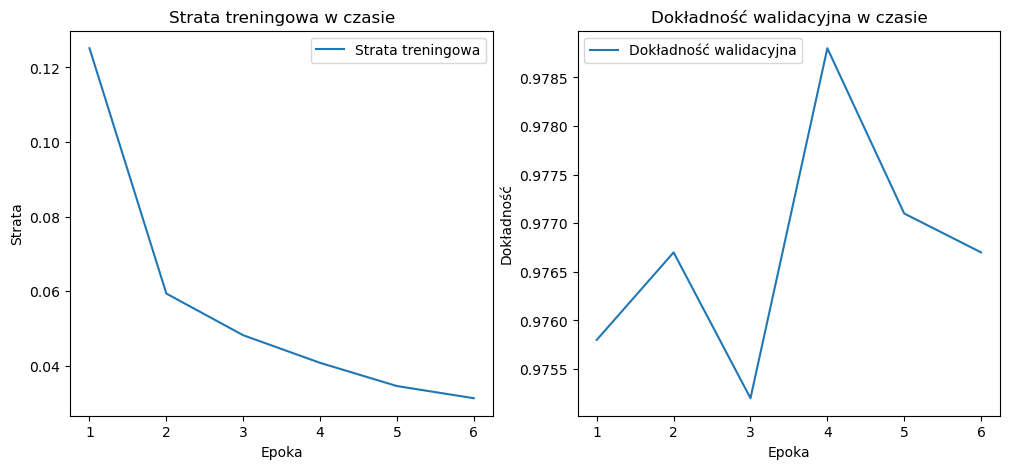

Accuracy of fine-tuned ViT on the test images: 97.39%


In [42]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from accelerate import Accelerator
import matplotlib.pyplot as plt

# Inicjalizuj accelerator
accelerator = Accelerator()

# Definiuj transformacje dla zbioru danych CIFAR-10
transform = transforms.Compose([
    transforms.Resize(224),  # Zmień rozmiar, aby dopasować do wejścia modelu
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Przygotuj zbiór danych CIFAR-10
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Podziel zbiór danych na treningowy i walidacyjny
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Funkcja do tworzenia DataLoader
def create_dataloader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
    return train_loader, val_loader, test_loader

# Załaduj wstępnie wytrenowany model Vision Transformer z timm i zmodyfikuj go dla CIFAR-10
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10)

# Zamroź początkowe warstwy
for name, param in model.named_parameters():
    if "head" not in name:  # Odblojuj tylko ostatnią warstwę
        param.requires_grad = False

# Definiuj funkcję straty i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Stwórz DataLoader'y
batch_size = 64
train_loader, val_loader, test_loader = create_dataloader(batch_size)

# Przygotuj z accelerator
model, optimizer, train_loader, val_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, val_loader, test_loader)

# Funkcja do trenowania modelu z wczesnym zatrzymaniem
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    model.train()
    train_losses = []
    val_accuracies = []
    best_val_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        current_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            accelerator.backward(loss)
            optimizer.step()
            current_loss += loss.item()
        
        avg_loss = current_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_acc = validate_model(model, val_loader)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch + 1}/{epochs}] Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        # Wczesne zatrzymanie
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            patience_counter = 0
            # Zapisz najlepszy model
            torch.save(model.state_dict(), 'best_model_vit.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping")
            break

    return train_losses, val_accuracies

# Funkcja do walidacji modelu
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Funkcja do testowania modelu
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Parametry treningu
epochs = 10
patience = 2  # Liczba epok do wczesnego zatrzymania, jeśli nie ma poprawy

# Ścieżka do zapisywania/wczytywania wag modelu
model_path = 'vit_cifar10.pth'

# Sprawdź, czy istnieje zapisany model
if os.path.exists(model_path):
    # Wczytaj zapisany model
    model.load_state_dict(torch.load(model_path, map_location=accelerator.device))
    print("Wczytano zapisany model.")
else:
    # Trenuj model
    train_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience)
    # Zapisz wagi modelu
    torch.save(model.state_dict(), model_path)
    print("Zapisano wytrenowany model.")

    # Wyświetl wykresy
    plt.figure(figsize=(12, 5))

    # Wykres strat treningowych
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Strata treningowa')
    plt.xlabel('Epoka')
    plt.ylabel('Strata')
    plt.title('Strata treningowa w czasie')
    plt.legend()

    # Wykres dokładności walidacyjnej
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Dokładność walidacyjna')
    plt.xlabel('Epoka')
    plt.ylabel('Dokładność')
    plt.title('Dokładność walidacyjna w czasie')
    plt.legend()

    plt.show()

# Oceń model
accuracy = test_model(model, test_loader)
print(f'Accuracy of fine-tuned ViT on the test images: {accuracy * 100:.2f}%')


In [43]:
# opróżnij gpu cache
torch.cuda.empty_cache()


Jak widać, model potrafił osiągnąć zaskakujące 97% dokładności na zbiorze testowym. Tak naprawdę, to nie jest wcale zadziwiające, biorąc pod uwagę, że oryginalny model vit-base-patch16-224 był treanowany na 14 milionach zdjeć (21,843 klas) oraz posiada 86,6 mln parametrów. Chociaż model ten jest bardzo duży oraz wymagający obliczeniowo (temperatury na moim mobilnym GPU przewyższały 100°C w pewnym momencie), to istnieją bardziej kompaktowe wersje ( ViT-Tiny czy też ViT-Small), które również osiągają bardzo przyzwoite wyniki przy mniejszym zużyciu pamięci i czasie obliczeń.

## Podsumowanie

Zbadaliśmy najbardziej popularne architektury uczenia maszynowego, począwszy od prostych modeli, takich jak regresja logistyczna, poprzez sieci neuronowe, konwolucyjne sieci neuronowe, aż po najnowsze modele SOTA, takie jak ResNet czy Vision Transformers. Widać, że wraz z rozwojem technologii, modele stają się coraz bardziej skomplikowane, ale również skuteczniejsze. Warto zauważyć, że wraz z rozwojem modeli, rosną również wymagania sprzętowe, co sprawia, że obliczenia na dużych modelach stają się coraz bardziej kosztowne. Dlatego też, w praktyce, warto wybierać modele, które są wystarczająco skuteczne, ale jednocześnie nie wymagają zbyt dużych zasobów obliczeniowych. Poniżej zamieszczamy tabelę z wynikami osiągniętymi przez poszczególne modele:

![Wyniki](images/results.png)
